# Feature Engineering and Model Building
Now that we have cleaned and preprocessed our data, we will engineer features relevant to predicting fraudulent providers. Subsequently, we will carry out feature selection and select the relevant features for model building.

In [190]:
# Please uncomment and run these lines if you don't have featuretools and woodwork installed
# !pip install featuretools
# !pip install woodwork

# Import libraries
import warnings

warnings.filterwarnings("ignore") # To hide deprecation warnings arising from underlying function calls made by featuretools

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from woodwork.logical_types import Boolean, Categorical
import category_encoders as ce
import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", 500)

## 6. Automated Feature Engineering
Instead of generating our features manually, we will make use of a technique known as automated feature engineering to help us generate more features. In particular, we will utilise deep feature synthesis (DFS) from the featuretools library to help us with this process. DFS applies aggregation and transformation operations on existing features and stacks them together to create new features. Subsequently, we can test and see the effectiveness of these new features in helping us to predict medicare fraud.

### 6.1 Import Preprocessed Datasets 

**Note: X_test.csv does not contain labels, while X_train1.csv, X_train2.csv and y_train.csv contain labels.**

Since we are going to be creating supervised and unsupervised models, it is important to note that we can only use the data in X_train1.csv, X_train2.csv, y_train.csv to train and test our supervised models.

Further down, x_train, x_val, y_train and y_val **<u>will only be obtained from the labeled data</u>** when we create our supervised models.

In [191]:
# Load preprocessed datasets
X_train1 = pd.read_csv('X_train1.csv')
X_train2 = pd.read_csv('X_train2.csv')
y_labels = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
X_labeled = pd.concat([X_train1, X_train2], ignore_index=True) # Combine into 1 training set

# As labels were provided for fraudulent providers only, we will retain the providers in our y_labels only.
y_providers = y_labels[['Provider', 'PotentialFraud']].drop_duplicates(ignore_index=True)

# Next we drop the labels in X_labeled_full
X_full = X_labeled[X_labeled.columns.difference(['BeneID',])]

display(X_full.head())
display(y_providers.head())

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
0,7.0,67.0,1.0,1,0,1,1,0,1,1,0,0,1,1,CLM46614,7,955.0,0.0,748.0,79788.0,4251.0,630.0,4673.0,6980.0,37270.0,341.0,5266.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,129,1,3204,36000,26000,12,12,70,60,0.0,0.0,PRV55912,1,0,39,0.0,1
1,3.0,67.0,3.0,1,0,1,1,0,1,1,0,0,1,1,CLM66048,3,57.0,0.0,57.0,5182.0,3461.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,230,1068.0,16,1,3204,36000,5000,12,12,70,60,3.0,0.0,PRV55907,1,0,39,0.0,1
2,4.0,67.0,12.0,1,0,1,1,0,1,1,0,0,1,1,CLM68358,4,1041.0,0.0,170.0,550.0,3416.0,2177.0,836.0,2242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,160,1,3204,36000,5000,12,12,70,60,0.0,14.0,PRV56046,1,0,39,0.0,1
3,9.0,96.0,55.0,0,0,1,1,1,0,1,0,0,1,1,CLM38412,9,360.0,0.0,2077.0,1423.0,630.0,2242.0,163.0,2941.0,412.0,5427.0,79788.0,100.0,0.0,0.0,0.0,0.0,360,1068.0,38,2,1068,5000,5000,12,12,320,250,12.0,15.0,PRV52405,2,0,1,0.0,1
4,18.0,72.0,2.0,0,0,1,0,1,1,1,1,0,0,0,CLM63689,18,1937.0,0.0,680.0,9099.0,292.0,5384.0,2765.0,6242.0,2442.0,580.0,831.0,854.0,0.0,0.0,0.0,0.0,780,1068.0,5,2,2136,21260,10000,12,12,100,120,5.0,0.0,PRV56614,1,1,45,0.0,1


,Provider,PotentialFraud
0,PRV55912,1
1,PRV55907,0
2,PRV56046,0
3,PRV52405,0
4,PRV56614,0


### 6.2 Train-Test Split

As deep feature synthesis carries out aggregation operations on our data, we will have to scale our data to avoid imbalancing issues. However, to avoid data leakage, we will need to prepare our scaler on training data and then use it to fit our test data. 

Thus we will first train-test split our data.

**Note: As we are aggregating over Provider, we will utilise GroupShuffleSplit to split the data by Provider to ensure that there is no train-test contamination.**

In [192]:
gss = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=4012)
split = gss.split(X_full, groups=X_full.Provider)
train_ix, test_ix = next(split)

X_train = X_full.loc[train_ix]
X_val = X_full.loc[test_ix]

providers_train = X_train.Provider.unique()
providers_val = X_val.Provider.unique()
y_train = y_providers[y_providers.Provider.isin(providers_train)]
y_val = y_providers[y_providers.Provider.isin(providers_val)]

In [193]:
# View X_train
display(X_train.head())
print(X_train.shape)

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
1,3.0,67.0,3.0,1,0,1,1,0,1,1,0,0,1,1,CLM66048,3,57.0,0.0,57.0,5182.0,3461.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,230,1068.0,16,1,3204,36000,5000,12,12,70,60,3.0,0.0,PRV55907,1,0,39,0.0,1
2,4.0,67.0,12.0,1,0,1,1,0,1,1,0,0,1,1,CLM68358,4,1041.0,0.0,170.0,550.0,3416.0,2177.0,836.0,2242.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,160,1,3204,36000,5000,12,12,70,60,0.0,14.0,PRV56046,1,0,39,0.0,1
3,9.0,96.0,55.0,0,0,1,1,1,0,1,0,0,1,1,CLM38412,9,360.0,0.0,2077.0,1423.0,630.0,2242.0,163.0,2941.0,412.0,5427.0,79788.0,100.0,0.0,0.0,0.0,0.0,360,1068.0,38,2,1068,5000,5000,12,12,320,250,12.0,15.0,PRV52405,2,0,1,0.0,1
6,6.0,70.0,8.0,1,1,0,0,1,1,0,0,1,1,0,CLM32075,6,173.0,0.0,185.0,7534.0,652.0,1290.0,13398.0,79788.0,5182.0,8333.0,4499.0,82.0,0.0,0.0,0.0,0.0,120,1068.0,64,1,1068,8000,8000,12,12,50,860,4.0,0.0,PRV54090,2,0,24,0.0,1
7,5.0,68.0,5.0,0,0,0,1,0,1,0,0,1,0,0,CLM62376,5,7304.0,0.0,327.0,39724.0,4984.0,7534.0,1009.0,15171.0,2197.0,4499.0,15246.0,1152.0,0.0,0.0,0.0,0.0,230,1068.0,79,1,1068,6000,6000,12,12,0,0,19.0,0.0,PRV51148,1,0,38,0.0,1


(447666, 51)


In [194]:
# View y_train
display(y_train.head())
print(y_train.shape)

,Provider,PotentialFraud
1,PRV55907,0
2,PRV56046,0
3,PRV52405,0
6,PRV54090,0
7,PRV51148,1


(4328, 2)


In [195]:
# View X_val
display(X_val.head())
print(X_val.shape)

,AdmitForDays,Age,AttendingPhysician_ce,ChronicCond_Alzheimer,ChronicCond_Cancer,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_Heartfailure,ChronicCond_IschemicHeart,ChronicCond_KidneyDisease,ChronicCond_ObstrPulmonary,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,ClaimID,ClaimProcessedForDays,ClmAdmitDiagnosisCode_ce,ClmDiagnosisCode_10_ce,ClmDiagnosisCode_1_ce,ClmDiagnosisCode_2_ce,ClmDiagnosisCode_3_ce,ClmDiagnosisCode_4_ce,ClmDiagnosisCode_5_ce,ClmDiagnosisCode_6_ce,ClmDiagnosisCode_7_ce,ClmDiagnosisCode_8_ce,ClmDiagnosisCode_9_ce,ClmProcedureCode_1_ce,ClmProcedureCode_2_ce,ClmProcedureCode_3_ce,ClmProcedureCode_4_ce,ClmProcedureCode_5_ce,County,DeductibleAmtPaid,DiagnosisGroupCode_ce,Gender,IPAnnualDeductibleAmt,IPAnnualReimbursementAmt,InscClaimAmtReimbursed,NoOfMonths_PartACov,NoOfMonths_PartBCov,OPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OperatingPhysician_ce,OtherPhysician_ce,Provider,Race,RenalDiseaseIndicator,State,isDead,is_inpatient
0,7.0,67.0,1.0,1,0,1,1,0,1,1,0,0,1,1,CLM46614,7,955.0,0.0,748.0,79788.0,4251.0,630.0,4673.0,6980.0,37270.0,341.0,5266.0,0.0,0.0,0.0,0.0,0.0,230,1068.0,129,1,3204,36000,26000,12,12,70,60,0.0,0.0,PRV55912,1,0,39,0.0,1
4,18.0,72.0,2.0,0,0,1,0,1,1,1,1,0,0,0,CLM63689,18,1937.0,0.0,680.0,9099.0,292.0,5384.0,2765.0,6242.0,2442.0,580.0,831.0,854.0,0.0,0.0,0.0,0.0,780,1068.0,5,2,2136,21260,10000,12,12,100,120,5.0,0.0,PRV56614,1,1,45,0.0,1
5,7.0,70.0,50.0,1,1,0,1,1,1,1,1,0,1,1,CLM70950,7,1915.0,0.0,405.0,768.0,2275.0,10181.0,158.0,203.0,5182.0,39724.0,3085.0,13.0,0.0,0.0,0.0,0.0,270,1068.0,35,2,2136,22000,8000,12,12,840,1400,50.0,50.0,PRV54986,1,0,31,0.0,1
10,9.0,64.0,31.0,1,0,1,1,1,1,1,1,0,1,1,CLM57949,9,7304.0,0.0,200.0,296.0,501.0,1423.0,5266.0,12185.0,805.0,868.0,2574.0,307.0,0.0,0.0,0.0,0.0,760,1068.0,90,2,2136,131140,102000,12,12,80,1650,23.0,0.0,PRV55193,1,0,34,0.0,1
13,6.0,87.0,19.0,0,0,1,1,1,1,1,1,0,1,0,CLM54944,6,3790.0,0.0,3790.0,1143.0,4603.0,3416.0,7938.0,15171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150,1068.0,153,2,2136,23000,6000,12,12,370,620,0.0,0.0,PRV52283,1,0,10,0.0,1


(110545, 51)


In [196]:
# View y_val
display(y_val.head())
print(y_val.shape)

,Provider,PotentialFraud
0,PRV55912,1
4,PRV56614,0
5,PRV54986,1
10,PRV55193,1
13,PRV52283,1


(1082, 2)


### 6.3 Data Scaling
Now that we have our train and validation set, we will proceed to scale our data using MinMax scaling.

In [197]:
# Initiate a Scaler
minmaxScaler = MinMaxScaler()

# Fit the scaler on train data
cols_to_scale = X_train.columns.difference(['ClaimID', 'Provider'])
minmaxScaler.fit(X_train[cols_to_scale])

# Transform train and test data
X_train[cols_to_scale] = minmaxScaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = minmaxScaler.transform(X_val[cols_to_scale])

### 6.4 Creation of EntitySets
Next, we add our datasets into an entityset and map out their relationships. An EntitySet is a collection of dataframes and the relationship between each dataframe.

**Note**: As we have a mixture of numerical, categorical and boolean data, we will need to explicitly list the categorical and boolean data so that the appropriate operations can be performed on them during DFS.

In [198]:
# During the preprocessing stage, these are the list of numerical, categorical and boolean data
numerical_cols = [
    "AdmitForDays",
    "Age",
    "ClaimProcessedForDays",
    "DeductibleAmtPaid",
    "IPAnnualDeductibleAmt",
    "IPAnnualReimbursementAmt",
    "InscClaimAmtReimbursed",
    "NoOfMonths_PartACov",
    "NoOfMonths_PartBCov",
    "OPAnnualDeductibleAmt",
    "OPAnnualReimbursementAmt",
]
categorical_cols = [
    "AttendingPhysician_ce",
    "ClaimID",
    "ClmAdmitDiagnosisCode_ce",
    "ClmDiagnosisCode_10_ce",
    "ClmDiagnosisCode_1_ce",
    "ClmDiagnosisCode_2_ce",
    "ClmDiagnosisCode_3_ce",
    "ClmDiagnosisCode_4_ce",
    "ClmDiagnosisCode_5_ce",
    "ClmDiagnosisCode_6_ce",
    "ClmDiagnosisCode_7_ce",
    "ClmDiagnosisCode_8_ce",
    "ClmDiagnosisCode_9_ce",
    "ClmProcedureCode_1_ce",
    "ClmProcedureCode_2_ce",
    "ClmProcedureCode_3_ce",
    "ClmProcedureCode_4_ce",
    "ClmProcedureCode_5_ce",
    "County",
    "DiagnosisGroupCode_ce",
    "Gender",
    "OperatingPhysician_ce",
    "OtherPhysician_ce",
    "Provider",
    "Race",
    "State",
]
bool_cols = [
    "ChronicCond_Alzheimer",
    "ChronicCond_Cancer",
    "ChronicCond_Depression",
    "ChronicCond_Diabetes",
    "ChronicCond_Heartfailure",
    "ChronicCond_IschemicHeart",
    "ChronicCond_KidneyDisease",
    "ChronicCond_ObstrPulmonary",
    "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis",
    "ChronicCond_stroke",
    "RenalDiseaseIndicator",
    "isDead",
    "is_inpatient",
    "RenalDiseaseIndicator",
]

In [199]:
# We will create a dictionary mapping for labelling the categorical and boolean data according to featuretools' documentation.
X_cat_bool_mapping = {
    cat_col: Categorical for cat_col in categorical_cols
}
X_cat_bool_mapping.update({
    bool_col: Boolean for bool_col in bool_cols
})

X_cat_bool_mapping

{'AttendingPhysician_ce': Categorical,
 'ClaimID': Categorical,
 'ClmAdmitDiagnosisCode_ce': Categorical,
 'ClmDiagnosisCode_10_ce': Categorical,
 'ClmDiagnosisCode_1_ce': Categorical,
 'ClmDiagnosisCode_2_ce': Categorical,
 'ClmDiagnosisCode_3_ce': Categorical,
 'ClmDiagnosisCode_4_ce': Categorical,
 'ClmDiagnosisCode_5_ce': Categorical,
 'ClmDiagnosisCode_6_ce': Categorical,
 'ClmDiagnosisCode_7_ce': Categorical,
 'ClmDiagnosisCode_8_ce': Categorical,
 'ClmDiagnosisCode_9_ce': Categorical,
 'ClmProcedureCode_1_ce': Categorical,
 'ClmProcedureCode_2_ce': Categorical,
 'ClmProcedureCode_3_ce': Categorical,
 'ClmProcedureCode_4_ce': Categorical,
 'ClmProcedureCode_5_ce': Categorical,
 'County': Categorical,
 'DiagnosisGroupCode_ce': Categorical,
 'Gender': Categorical,
 'OperatingPhysician_ce': Categorical,
 'OtherPhysician_ce': Categorical,
 'Provider': Categorical,
 'Race': Categorical,
 'State': Categorical,
 'ChronicCond_Alzheimer': Boolean,
 'ChronicCond_Cancer': Boolean,
 'Chronic

In [200]:
y_cat_bool_mapping = {
    'Provider' : Categorical,
    'PotentialFraud': Boolean
}
y_cat_bool_mapping

{'Provider': Categorical, 'PotentialFraud': Boolean}

In [201]:
# Each dataset added into the entityset requires an index column that can uniquely identify every row.
# Hence we will first find a column to use as index in X_full
print(X_train.nunique().sort_values(
    ascending=False).head())  # We will use ClaimID

ClaimID                     447666
Provider                      4328
IPAnnualReimbursementAmt      2973
OPAnnualReimbursementAmt      2066
ClmDiagnosisCode_1_ce          948
dtype: int64


In [202]:
# Add data to entityset
entityset_train = ft.EntitySet(id="train")
entityset_train = entityset_train.add_dataframe(
    dataframe=X_train, dataframe_name="X", index="ClaimID",
    logical_types=X_cat_bool_mapping
)
entityset_train = entityset_train.add_dataframe(
    dataframe=y_train, dataframe_name="y", index="Provider",
    logical_types=y_cat_bool_mapping
)

entityset_val = ft.EntitySet(id="val")
entityset_val = entityset_val.add_dataframe(
    dataframe=X_val, dataframe_name="X", index="ClaimID",
    logical_types=X_cat_bool_mapping
)
entityset_val = entityset_val.add_dataframe(
    dataframe=y_val, dataframe_name="y", index="Provider",
    logical_types=y_cat_bool_mapping
)

display(entityset_train)
display(entityset_val)

Entityset: train
  DataFrames:
    X [Rows: 447666, Columns: 51]
    y [Rows: 4328, Columns: 2]
  Relationships:
    No relationships

Entityset: val
  DataFrames:
    X [Rows: 110545, Columns: 51]
    y [Rows: 1082, Columns: 2]
  Relationships:
    No relationships

In [203]:
# Next we outline the relationships between our dataframes
entityset_train = entityset_train.add_relationship(
    parent_dataframe_name='y',
    parent_column_name='Provider',
    child_dataframe_name='X',
    child_column_name='Provider'
)

entityset_val = entityset_val.add_relationship(
    parent_dataframe_name='y',
    parent_column_name='Provider',
    child_dataframe_name='X',
    child_column_name='Provider'
)

display(entityset_train)
display(entityset_val)

Entityset: train
  DataFrames:
    X [Rows: 447666, Columns: 51]
    y [Rows: 4328, Columns: 2]
  Relationships:
    X.Provider -> y.Provider

Entityset: val
  DataFrames:
    X [Rows: 110545, Columns: 51]
    y [Rows: 1082, Columns: 2]
  Relationships:
    X.Provider -> y.Provider

### 6.5 Deep Feature Synthesis
Now that we have our entitysets, we will carry out deep feature synthesis on the training and validation data. 

In [204]:
# Now we run deep feature synthesis and create a feature matrix for each provider.
feature_matrix_providers_train, feature_defs_train = ft.dfs(
    entityset=entityset_train, target_dataframe_name="y")
feature_matrix_providers_val, feature_defs_val = ft.dfs(
    entityset=entityset_val, target_dataframe_name="y")

display(feature_matrix_providers_train.head())
print(feature_matrix_providers_train.shape)
display(feature_matrix_providers_val.head())
print(feature_matrix_providers_val.shape)

,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55907,False,243,0.805556,0.973333,0.777778,1.0,0.135974,0.476190,0.256,1.0,1

(4328, 130)


,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55912,True,107,0.777778,1.000000,0.750000,1.0,0.188232,0.475010,0.416,1.0,1.

(1082, 130)


# Model Building

In [205]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering, KMeans

# because its unsupervised learning, there is no Y_train & Y_test
X_train = feature_matrix_providers_train
X_test = feature_matrix_providers_val

In [206]:
# confirm that all columns are numerical
numerical_cols = feature_matrix_providers_train.select_dtypes(include=['number'])
len(numerical_cols)

4328

In [207]:
# observe the distribution of columns 
X_train.columns[X_train.isna().any()].tolist()

['SKEW(X.AdmitForDays)',
 'SKEW(X.Age)',
 'SKEW(X.ClaimProcessedForDays)',
 'SKEW(X.DeductibleAmtPaid)',
 'SKEW(X.IPAnnualDeductibleAmt)',
 'SKEW(X.IPAnnualReimbursementAmt)',
 'SKEW(X.InscClaimAmtReimbursed)',
 'SKEW(X.NoOfMonths_PartACov)',
 'SKEW(X.NoOfMonths_PartBCov)',
 'SKEW(X.OPAnnualDeductibleAmt)',
 'SKEW(X.OPAnnualReimbursementAmt)',
 'STD(X.AdmitForDays)',
 'STD(X.Age)',
 'STD(X.ClaimProcessedForDays)',
 'STD(X.DeductibleAmtPaid)',
 'STD(X.IPAnnualDeductibleAmt)',
 'STD(X.IPAnnualReimbursementAmt)',
 'STD(X.InscClaimAmtReimbursed)',
 'STD(X.NoOfMonths_PartACov)',
 'STD(X.NoOfMonths_PartBCov)',
 'STD(X.OPAnnualDeductibleAmt)',
 'STD(X.OPAnnualReimbursementAmt)']

In [208]:
# pick some random variable to observe why skew and std is NaN
subset = X_train.filter(like="Age", axis=1)
subset[subset.isna().any(axis=1)]

,MAX(X.Age),MEAN(X.Age),MIN(X.Age),SKEW(X.Age),STD(X.Age),SUM(X.Age)
Provider,,,,,,
PRV51618,0.533333,0.533333,0.533333,NaN,NaN,0.533333
PRV55156,0.586667,0.586667,0.586667,NaN,NaN,0.586667
PRV52970,0.680000,0.680000,0.680000,NaN,NaN,0.680000
PRV53517,0.773333,0.673333,0.573333,NaN,0.141421,1.346667
PRV55144,0.600000,0.466667,0.333333,NaN,0.188562,0.933333
...,...,...,...,...,...,...
PRV54050,0.786667,0.786667,0.786667,NaN,NaN,0.786667
PRV54302,0.760000,0.760000,0.760000,NaN,NaN,0.760000
PRV57762,0.560000,0.560000,0.560000,NaN,NaN,0.560000


Observe that columns with NaNs are those related to Skewness and Standard Deviation. (But a STD of 0 does not necessarily equate to a skew of 0)


When Skewness is undefined, it could be instances when the distribution is extremely skewed, forcing the denominator in the skew formula close to 0. ALternatively, all the observations might not have any variation, (ie: min == max) causing the square root of zero in the std calculation to result in NaN. Hence, check for variance in the rows with NaN by max - min > 0. If = 0, no variation and both skewness and std can be set to 0.

In [209]:
subset['variance'] = subset['MAX(X.Age)']- subset['MIN(X.Age)']
subsubset = subset[subset.isna().any(axis=1)]
len(subsubset[subsubset['variance'] == 0])

195

In [210]:
# not all the rows with NaN skew/std are 0. But for those that are, replace with NaN 
skew_columns = X_train.filter(like="SKEW", axis=1)
std_columns = X_train.filter(like="STD", axis=1)

for col in skew_columns:
    X_train[col] = X_train[col].fillna(0.0)
    X_test[col] = X_test[col].fillna(0.0)

for col in std_columns:
    X_train[col] = X_train[col].fillna(0.0)
    X_test[col] = X_test[col].fillna(0.0)


In [211]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [212]:
# convert potential fraud to binary
X_train['PotentialFraud'] = X_train['PotentialFraud'].apply(lambda x: 1 if x == True else 0)
X_test['PotentialFraud'] = X_test['PotentialFraud'].apply(lambda x: 1 if x == True else 0)
X_train.head()

,PotentialFraud,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),MODE(X.AttendingPhysician_ce),MODE(X.ClmAdmitDiagnosisCode_ce),MODE(X.ClmDiagnosisCode_10_ce),MODE(X.ClmDiagnosisCode_1_ce),MODE(X.ClmDiagnosisCode_2_ce),MODE(X.ClmDiagnosisCode_3_ce),MODE(X.ClmDiagnosisCode_4_ce),MODE(X.ClmDiagnosisCode_5_ce),MODE(X.ClmDiagnosisCode_6_ce),MODE(X.ClmDiagnosisCode_7_ce),MODE(X.ClmDiagnosisCode_8_ce),MODE(X.ClmDiagnosisCode_9_ce),MODE(X.ClmProcedureCode_1_ce),MODE(X.ClmProcedureCode_2_ce),MODE(X.ClmProcedureCode_3_ce),MODE(X.ClmProcedureCode_4_ce),MODE(X.ClmProcedureCode_5_ce),MODE(X.County),MODE(X.DiagnosisGroupCode_ce),MODE(X.Gender),MODE(X.OperatingPhysician_ce),MODE(X.OtherPhysician_ce),MODE(X.Race),MODE(X.State),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt)
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV55907,0,243,0.805556,0.973333,0.777778,1.0,0.135974,0.476190,0.256,1.0,1.0,0

In [213]:
object_cols = X_train.select_dtypes(include=['category']).columns
object_cols

Index(['MODE(X.AttendingPhysician_ce)', 'MODE(X.ClmAdmitDiagnosisCode_ce)',
       'MODE(X.ClmDiagnosisCode_10_ce)', 'MODE(X.ClmDiagnosisCode_1_ce)',
       'MODE(X.ClmDiagnosisCode_2_ce)', 'MODE(X.ClmDiagnosisCode_3_ce)',
       'MODE(X.ClmDiagnosisCode_4_ce)', 'MODE(X.ClmDiagnosisCode_5_ce)',
       'MODE(X.ClmDiagnosisCode_6_ce)', 'MODE(X.ClmDiagnosisCode_7_ce)',
       'MODE(X.ClmDiagnosisCode_8_ce)', 'MODE(X.ClmDiagnosisCode_9_ce)',
       'MODE(X.ClmProcedureCode_1_ce)', 'MODE(X.ClmProcedureCode_2_ce)',
       'MODE(X.ClmProcedureCode_3_ce)', 'MODE(X.ClmProcedureCode_4_ce)',
       'MODE(X.ClmProcedureCode_5_ce)', 'MODE(X.County)',
       'MODE(X.DiagnosisGroupCode_ce)', 'MODE(X.Gender)',
       'MODE(X.OperatingPhysician_ce)', 'MODE(X.OtherPhysician_ce)',
       'MODE(X.Race)', 'MODE(X.State)'],
      dtype='object')

All category columns are MODE -- can be dropped due to collinearity with the original columns.

In [214]:
# drop all mode columns
mode_columns = X_train.filter(like="MODE", axis=1)

X_train.drop(mode_columns, axis=1, inplace=True)
X_test.drop(mode_columns, axis=1, inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4328 entries, PRV55907 to PRV53083
Columns: 106 entries, PotentialFraud to SUM(X.OPAnnualReimbursementAmt)
dtypes: Int64(25), float64(80), int64(1)
memory usage: 3.8 MB


# SMOTE -- ADASYN

To oversample the minority fraud class. Done after FE as reccomended by SMOTE paper 

In [215]:
train = X_train.copy()
X_train = train.drop('PotentialFraud', axis=1)
Y_train = train['PotentialFraud']

In [216]:
# convert entire dataframe to float64 to fit into tensor
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [217]:
# %pip install imblearn
from imblearn.over_sampling import ADASYN
from collections import Counter

counter = Counter(Y_train)
print('Before', counter)
ada = ADASYN(random_state=42)
X_train, Y_train = ada.fit_resample(X_train, Y_train)

counter = Counter(Y_train)
print('After', counter)

Before Counter({0: 3927, 1: 401})
After Counter({0: 3927, 1: 3919})


# Unsupervised Learning -- Clustering

3 types of clustering will be employed, with the distortion score being used to determine the best model of the 3.


_____________________________________________________________________________________________________________________
### Types of clustering:

Kmeans Clustering

Agglomerative clustering

_____________________________________________________________________________________________________________________

The purpose of clustering is to find groups of observations with similar characteristics. Hence, target variable potential fraud will be left inside the input feature matrix, where clusters with 'Potential Fraud' closer to 1.0 may have characteristics relevant to fraudulent activity. Additionally, since all clustering methods aforementioned are unsupervised learning, there will be no Y (target) datasets. The purpose of these models are to identify sets of suspicious characteristics associated with fraud, contrary to non-fraudulent observations/ clusters.

## Clustering without PCA dimensionality reduction

In [218]:
# for clustering purposes, join back the target values to the training set as explained above
# will be dropped again during MLP
X_train['PotentialFraud'] =  Y_train
X_train.head()

,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),MAX(X.OPAnnualDeductibleAmt),MAX(X.OPAnnualReimbursementAmt),MEAN(X.AdmitForDays),MEAN(X.Age),MEAN(X.ClaimProcessedForDays),MEAN(X.DeductibleAmtPaid),MEAN(X.IPAnnualDeductibleAmt),MEAN(X.IPAnnualReimbursementAmt),MEAN(X.InscClaimAmtReimbursed),MEAN(X.NoOfMonths_PartACov),MEAN(X.NoOfMonths_PartBCov),MEAN(X.OPAnnualDeductibleAmt),MEAN(X.OPAnnualReimbursementAmt),MIN(X.AdmitForDays),MIN(X.Age),MIN(X.ClaimProcessedForDays),MIN(X.DeductibleAmtPaid),MIN(X.IPAnnualDeductibleAmt),MIN(X.IPAnnualReimbursementAmt),MIN(X.InscClaimAmtReimbursed),MIN(X.NoOfMonths_PartACov),MIN(X.NoOfMonths_PartBCov),MIN(X.OPAnnualDeductibleAmt),MIN(X.OPAnnualReimbursementAmt),NUM_UNIQUE(X.AttendingPhysician_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_10_ce),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),NUM_UNIQUE(X.ClmDiagnosisCode_6_ce),NUM_UNIQUE(X.ClmDiagnosisCode_7_ce),NUM_UNIQUE(X.ClmDiagnosisCode_8_ce),NUM_UNIQUE(X.ClmDiagnosisCode_9_ce),NUM_UNIQUE(X.ClmProcedureCode_1_ce),NUM_UNIQUE(X.ClmProcedureCode_2_ce),NUM_UNIQUE(X.ClmProcedureCode_3_ce),NUM_UNIQUE(X.ClmProcedureCode_4_ce),NUM_UNIQUE(X.ClmProcedureCode_5_ce),NUM_UNIQUE(X.County),NUM_UNIQUE(X.DiagnosisGroupCode_ce),NUM_UNIQUE(X.Gender),NUM_UNIQUE(X.OperatingPhysician_ce),NUM_UNIQUE(X.OtherPhysician_ce),NUM_UNIQUE(X.Race),NUM_UNIQUE(X.State),PERCENT_TRUE(X.ChronicCond_Alzheimer),PERCENT_TRUE(X.ChronicCond_Cancer),PERCENT_TRUE(X.ChronicCond_Depression),PERCENT_TRUE(X.ChronicCond_Diabetes),PERCENT_TRUE(X.ChronicCond_Heartfailure),PERCENT_TRUE(X.ChronicCond_IschemicHeart),PERCENT_TRUE(X.ChronicCond_KidneyDisease),PERCENT_TRUE(X.ChronicCond_ObstrPulmonary),PERCENT_TRUE(X.ChronicCond_Osteoporasis),PERCENT_TRUE(X.ChronicCond_rheumatoidarthritis),PERCENT_TRUE(X.ChronicCond_stroke),PERCENT_TRUE(X.RenalDiseaseIndicator),PERCENT_TRUE(X.isDead),PERCENT_TRUE(X.is_inpatient),SKEW(X.AdmitForDays),SKEW(X.Age),SKEW(X.ClaimProcessedForDays),SKEW(X.DeductibleAmtPaid),SKEW(X.IPAnnualDeductibleAmt),SKEW(X.IPAnnualReimbursementAmt),SKEW(X.InscClaimAmtReimbursed),SKEW(X.NoOfMonths_PartACov),SKEW(X.NoOfMonths_PartBCov),SKEW(X.OPAnnualDeductibleAmt),SKEW(X.OPAnnualReimbursementAmt),STD(X.AdmitForDays),STD(X.Age),STD(X.ClaimProcessedForDays),STD(X.DeductibleAmtPaid),STD(X.IPAnnualDeductibleAmt),STD(X.IPAnnualReimbursementAmt),STD(X.InscClaimAmtReimbursed),STD(X.NoOfMonths_PartACov),STD(X.NoOfMonths_PartBCov),STD(X.OPAnnualDeductibleAmt),STD(X.OPAnnualReimbursementAmt),SUM(X.AdmitForDays),SUM(X.Age),SUM(X.ClaimProcessedForDays),SUM(X.DeductibleAmtPaid),SUM(X.IPAnnualDeductibleAmt),SUM(X.IPAnnualReimbursementAmt),SUM(X.InscClaimAmtReimbursed),SUM(X.NoOfMonths_PartACov),SUM(X.NoOfMonths_PartBCov),SUM(X.OPAnnualDeductibleAmt),SUM(X.OPAnnualReimbursementAmt),PotentialFraud
0,243.0,0.805556,0.973333,0.777778,1.0,0.135974,0.476190,0.256,1.0,1.0,0.526012,0.257595,0.046411,0.633196,0.075446,0.248493,0.022034,0.094472,0.019693,0.979424,0.995199,0.051054,0.024973,0.0,0.026667,0.0,0.0,0.0,0.047206,0.00000,0.0,0.000000,0.0,0.000679,14.0,81.0,6.0,181.0,113.0,104.0,90.0,75.0,63.0,56.0,51.0,46.0,28.0,6.0,3.0,1.0,1.0,33.0,41.0,2.0,13.0,11.0,3.0,7.0,0.493827,0.205761,0.497942,0.773663,0.654321,0.777778,0.456790,0.370370,0.345679,0.386831,0.148148,0.242798,0.004115,0.246914,3.689757,-0.794006,2.529283,1.179012,1.198962,2.341884,3.052804,-6.796358,-15.284979,4.091988,3.946327,0.107311,0.180441,0.153474,0.431337,0.026072,0.075429,0.041269,0.142253,0.064548,0.078446,0.041015,11.277778,153.866667,18.333333,60.383895,5.354306,22.956688,4.78544,238.0,241.833333,12.406069,6.068524,0
1,20.0,0.388889,0.906667,0.361111,1.0,0.188232,0.849708,0.320,1.0,1.0,

Elbow Method to determine the number of clusters to be formed for Agglomerative Clustering:


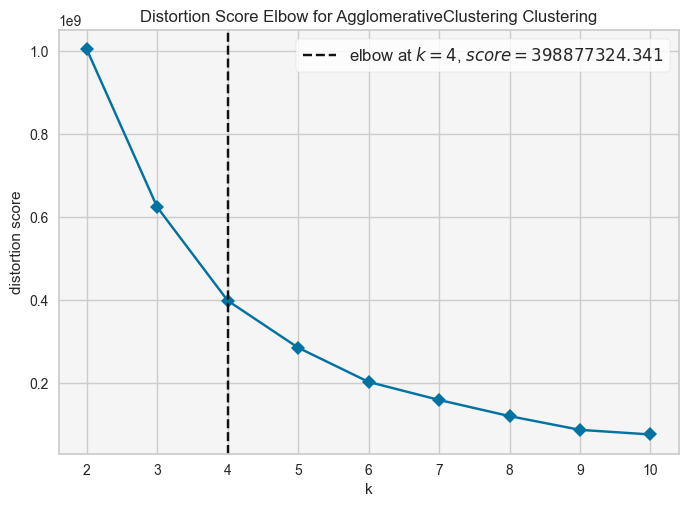

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [219]:
print('Elbow Method to determine the number of clusters to be formed for Agglomerative Clustering:')
Elbow_M = KElbowVisualizer(
    AgglomerativeClustering(),
    k=10,
    locate_elbow=True,
    timings=False
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(X_train)
Elbow_M.show()


Elbow Method to determine the number of clusters to be formed for KMeans Clustering:


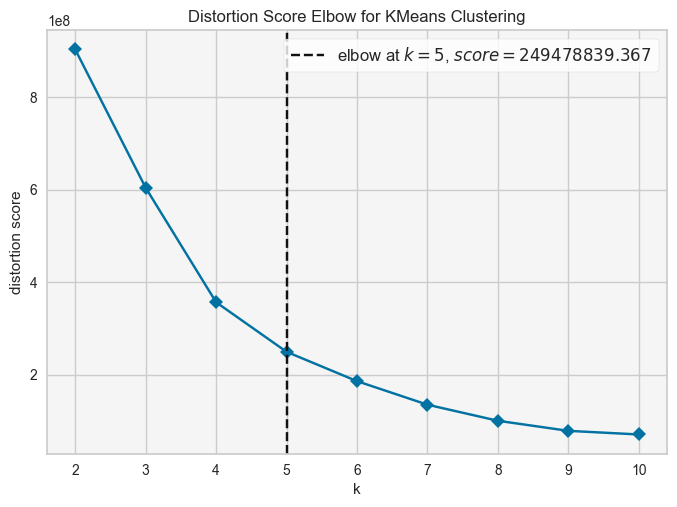

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [220]:
print('Elbow Method to determine the number of clusters to be formed for KMeans Clustering:')
Elbow_M = KElbowVisualizer(
    KMeans(n_init='auto'),
    locate_elbow=True,
    timings=False,
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(X_train)
Elbow_M.show()


Horrifying distortion score for both clustering techniques. Try with PCA dimensionality reduced matrix, if there is >10% improvement, proceed henceforth with PCA-ed matrix.

### Dimensionality Reduction -- Principal Component Analysis

In [221]:
from sklearn.decomposition import PCA

# Perform PCA with 10 components on the standard scaled dataset
pca = PCA(n_components=10, random_state=0)
pca.fit(X_train)

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca.transform(X_train), 
                      columns=["col1", "col2", "col3","col4","col5",'col6','col7','col8','col9','col10'])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

        count          mean         std         min         25%         50%  \
col1   7846.0 -1.112815e-14  509.513598 -291.732734 -251.448132 -171.364977   
col2   7846.0 -7.418769e-15   66.264762 -320.750987  -31.070669   12.613381   
col3   7846.0  1.854692e-15   40.444271  -99.483455  -15.684601   -0.589563   
col4   7846.0 -2.897957e-16    9.248690  -38.969170   -4.948480   -1.118327   
col5   7846.0 -2.782038e-15    5.866393  -63.058781   -2.604101    0.338446   
col6   7846.0 -1.072244e-15    5.087727  -39.335998   -1.746014   -0.333726   
col7   7846.0 -2.318365e-16    4.903823  -92.553174   -2.139301    0.174296   
col8   7846.0 -3.071834e-15    4.469480  -53.599696   -1.261622   -0.310610   
col9   7846.0 -4.346935e-16    3.981276  -32.800111   -1.587404   -0.206474   
col10  7846.0  1.782243e-15    3.831384  -26.322129   -1.697811   -0.311527   

             75%           max  
col1   32.059432  14733.146290  
col2   40.091413   2905.804204  
col3   12.242112    906.841743 

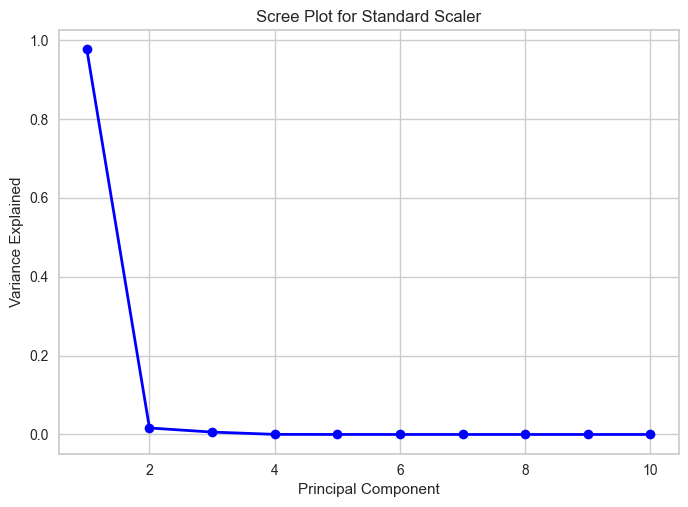

In [222]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot for Standard Scaler')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Ideal PC = 2 for minmax() scaled auto FE

In [223]:
# Perform PCA with 2 components on the standard scaled dataset
pca = PCA(n_components=2, random_state=0)
pca.fit(X_train)

# Create a DataFrame to store the PCA results
PCA_ds = pd.DataFrame(pca.transform(X_train), 
                      columns=["col1", "col2"])

# Display summary statistics of the PCA results
PCA_summary = PCA_ds.describe().T
print(PCA_summary)

       count          mean         std         min         25%         50%  \
col1  7846.0 -2.225631e-14  509.513598 -291.732734 -251.448132 -171.364977   
col2  7846.0 -3.709384e-15   66.264762 -320.750987  -31.070669   12.613381   

            75%           max  
col1  32.059432  14733.146290  
col2  40.091413   2905.804204  


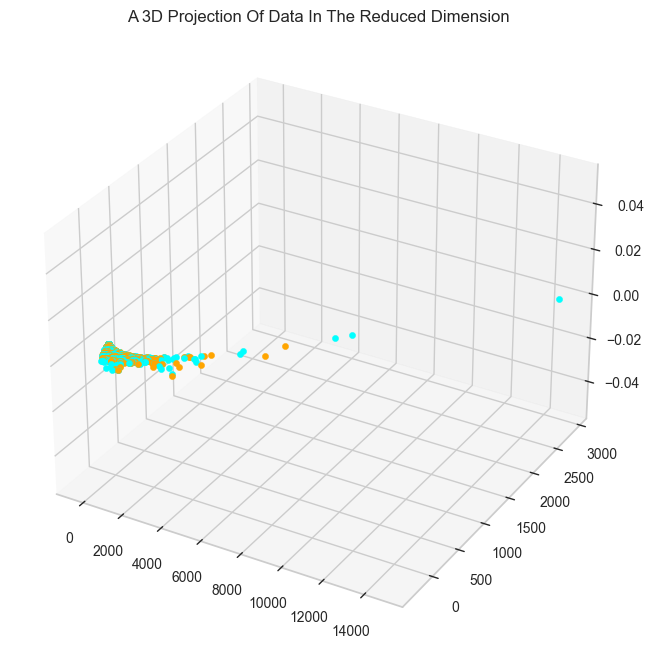

In [224]:
# Import necessary libraries
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D projection

# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]

# Define colors for the scatter plot
colors = ["orange", "cyan"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot with bright colors
for i in range(len(x)):
    ax.scatter(x[i], y[i], c=colors[i % len(colors)], marker="o")

# Set the title
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")

# Show the plot
plt.show()

Elbow Method to determine the number of clusters to be formed with Agglomerative CLustering and PCA:


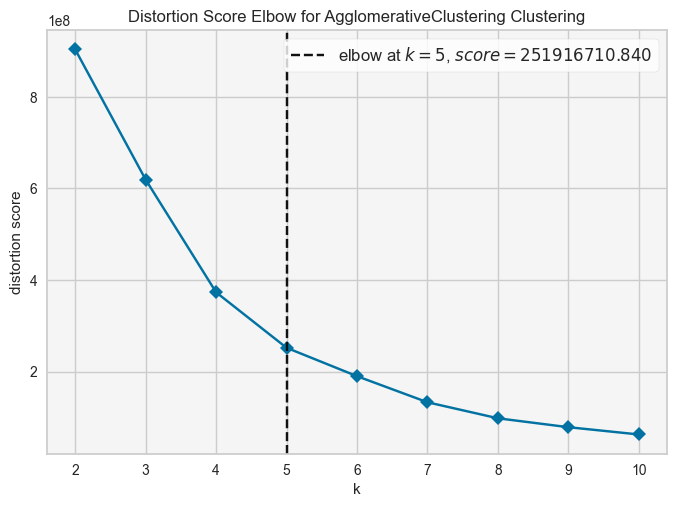

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [225]:
print('Elbow Method to determine the number of clusters to be formed with Agglomerative CLustering and PCA:')
Elbow_M = KElbowVisualizer(
    AgglomerativeClustering(),
    k=10,
    locate_elbow=True,
    timings=False
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(PCA_ds)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed for KMeans Clustering:


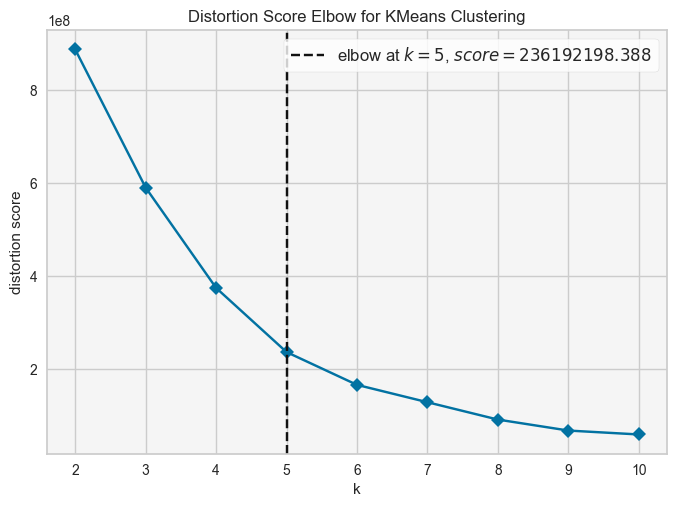

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [226]:
print('Elbow Method to determine the number of clusters to be formed for KMeans Clustering:')
Elbow_M = KElbowVisualizer(
    KMeans(n_init='auto'),
    locate_elbow=True,
    timings=False,
)

# Set a different background color (e.g., light gray)
Elbow_M.ax.set_facecolor("#F5F5F5")

Elbow_M.fit(PCA_ds)
Elbow_M.show()


Some improvment in performance but overall still objectively bad. Anyway, fit to continue with PCA processed dataset with 4 clusters for both kmeans and agglomerative clustering.

#### Agglomerative Clustering with 5 clusters

In [227]:
# Initialize the Agglomerative Clustering model with 5 clusters
AC = AgglomerativeClustering(n_clusters=5)

# Fit the model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)

# Add the cluster labels to the PCA DataFrame
PCA_ds["Clusters"] = yhat_AC

# Add the Clusters feature to the original DataFrame
X_train["Clusters"] = yhat_AC

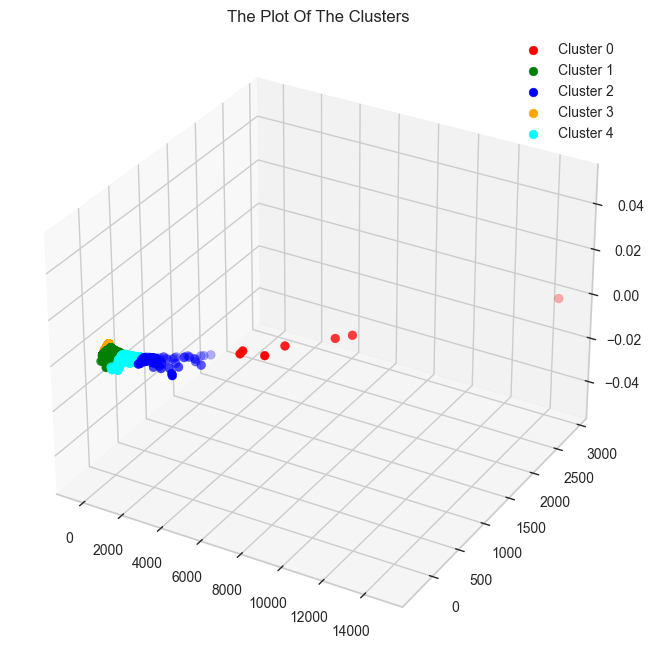

In [228]:
# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]

# Define colors for the clusters
colors = ["red", "green", "blue", "orange", "cyan"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")

# Scatter plot with cluster-specific colors
for cluster_id in range(len(colors)):
    cluster_data = PCA_ds[PCA_ds["Clusters"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

# Set the title
ax.set_title("The Plot Of The Clusters")

# Add a legend
ax.legend()

# Show the plot
plt.show()


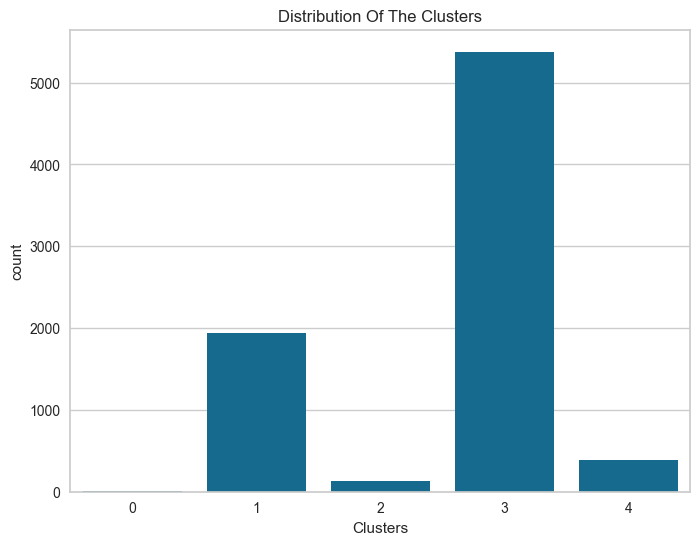

In [229]:
# Create a countplot of the cluster distribution
plt.figure(figsize=(8, 6))
countplot = sns.countplot(x=X_train["Clusters"])

# Set the title
countplot.set_title("Distribution Of The Clusters")

# Show the plot
plt.show()

In [230]:
X_train.columns

Index(['COUNT(X)', 'MAX(X.AdmitForDays)', 'MAX(X.Age)',
       'MAX(X.ClaimProcessedForDays)', 'MAX(X.DeductibleAmtPaid)',
       'MAX(X.IPAnnualDeductibleAmt)', 'MAX(X.IPAnnualReimbursementAmt)',
       'MAX(X.InscClaimAmtReimbursed)', 'MAX(X.NoOfMonths_PartACov)',
       'MAX(X.NoOfMonths_PartBCov)',
       ...
       'SUM(X.DeductibleAmtPaid)', 'SUM(X.IPAnnualDeductibleAmt)',
       'SUM(X.IPAnnualReimbursementAmt)', 'SUM(X.InscClaimAmtReimbursed)',
       'SUM(X.NoOfMonths_PartACov)', 'SUM(X.NoOfMonths_PartBCov)',
       'SUM(X.OPAnnualDeductibleAmt)', 'SUM(X.OPAnnualReimbursementAmt)',
       'PotentialFraud', 'Clusters'],
      dtype='object', length=107)

In [231]:
len(X_train[X_train["PotentialFraud"]==0])/ len(X_train[X_train["PotentialFraud"]==1])

1.0020413370757846

In [232]:
X_train.groupby(['Clusters', 'PotentialFraud']).count()

COUNT(X)  MAX(X.AdmitForDays)  MAX(X.Age)  \
Clusters PotentialFraud                                              
0        1                      7                    7           7   
1        0                    522                  522         522   
         1                   1418                 1418        1418   
2        0                     12                   12          12   
         1                    123                  123         123   
3        0                   3325                 3325        3325   
         1                   2053                 2053        2053   
4        0                     68                   68          68   
         1                    318                  318         318   

                         MAX(X.ClaimProcessedForDays)  \
Clusters PotentialFraud                                 
0        1                                          7   
1        0                                        522   
         1                                       1418   
2        0                                         12   
         1                                        123   
3        0                                       3325   
         1                                       2053   
4        0                                         68   
         1                                        318   

                         MAX(X.DeductibleAmtPaid)  \
Clusters PotentialFraud                             
0        1                                      7   
1        0                                    522   
         1                                   1418   
2        0                                     12   
         1                                    123   
3        0                                   3325   
         1                                   2053   
4        0                                     68   
         1                                    318   

                         MAX(X.IPAnnualDeductibleAmt)  \
Clusters PotentialFraud                                 
0        1                                          7   
1        0                                        522   
         1                                       1418   
2        0                                         12   
         1                                        123   
3        0                                       3325   
         1                                       2053   
4        0                                         68   
         1                                        318   

                         MAX(X.IPAnnualReimbursementAmt)  \
Clusters PotentialFraud                                    
0        1                                             7   
1        0                                           522   
         1                                          1418   
2        0                                            12   
         1                                           123   
3        0                                          3325   
         1                                          2053   
4        0                                            68   
         1                                           318   

                         MAX(X.InscClaimAmtReimbursed)  \
Clusters PotentialFraud                                  
0        1                                           7   
1        0                                         522   
         1                                        1418   
2        0                                          12   
         1                                         123   
3        0                                        3325   
         1                                        2053   
4        0                                          68   
         1                                         318   

                         MAX(X.NoOfMonths_PartACov)  \
Clusters PotentialFraud                               
0   

Severe class imbalance that does not closely reflect distribution of fraud in data, but it does seem that cluster 2 has a greater proportion and distribution of non-frauds. This means that observations without characteristics similar to cluster 2 can be considered suspicious.

#### KMeans Clustering with 5 clusters

In [233]:
# Initialize the Agglomerative Clustering model with 5 clusters
KM = KMeans(n_clusters=5, n_init='auto')

# Fit the model and predict clusters
yhat_KM = KM.fit_predict(PCA_ds)

# Add the cluster labels to the PCA DataFrame
PCA_ds["Clusters"] = yhat_KM

# Add the Clusters feature to the original DataFrame
X_train["Clusters"] = yhat_KM

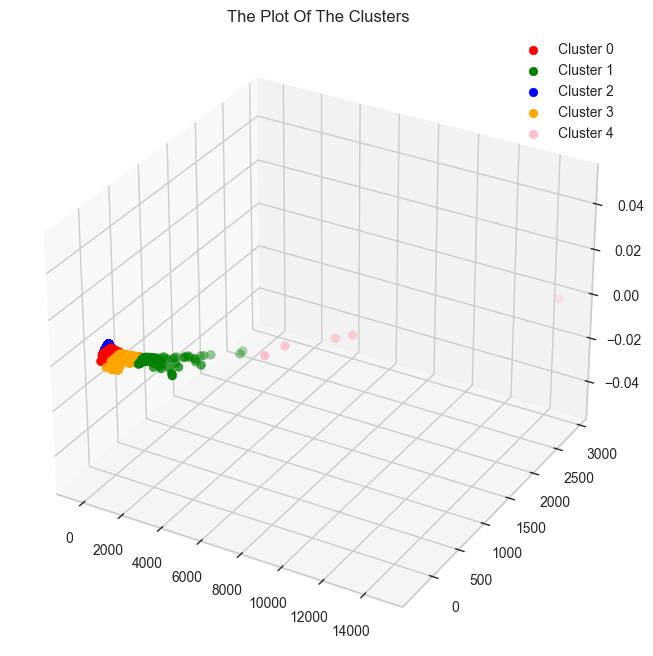

In [234]:
# Extract the PCA components
x = PCA_ds["col1"]
y = PCA_ds["col2"]

# Define colors for the clusters
colors = ["red", "green", "blue", "orange", "pink"]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")

# Scatter plot with cluster-specific colors
for cluster_id in range(len(colors)):
    cluster_data = PCA_ds[PCA_ds["Clusters"] == cluster_id]
    ax.scatter(
        cluster_data["col1"],
        cluster_data["col2"],
        s=40,
        c=colors[cluster_id],
        marker='o',
        label=f'Cluster {cluster_id}'
    )

# Set the title
ax.set_title("The Plot Of The Clusters")

# Add a legend
ax.legend()

# Show the plot
plt.show()


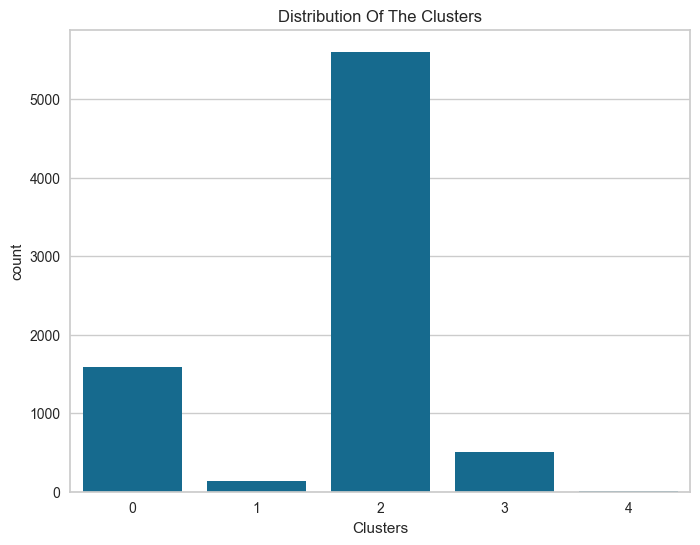

In [235]:
# Create a countplot of the cluster distribution
plt.figure(figsize=(8, 6))
countplot = sns.countplot(x=X_train["Clusters"])

# Set the title
countplot.set_title("Distribution Of The Clusters")

# Show the plot
plt.show()

In [236]:
X_train.groupby(['Clusters', 'PotentialFraud']).count()

COUNT(X)  MAX(X.AdmitForDays)  MAX(X.Age)  \
Clusters PotentialFraud                                              
0        0                    406                  406         406   
         1                   1182                 1182        1182   
1        0                     12                   12          12   
         1                    125                  125         125   
2        0                   3412                 3412        3412   
         1                   2195                 2195        2195   
3        0                     97                   97          97   
         1                    412                  412         412   
4        1                      5                    5           5   

                         MAX(X.ClaimProcessedForDays)  \
Clusters PotentialFraud                                 
0        0                                        406   
         1                                       1182   
1        0                                         12   
         1                                        125   
2        0                                       3412   
         1                                       2195   
3        0                                         97   
         1                                        412   
4        1                                          5   

                         MAX(X.DeductibleAmtPaid)  \
Clusters PotentialFraud                             
0        0                                    406   
         1                                   1182   
1        0                                     12   
         1                                    125   
2        0                                   3412   
         1                                   2195   
3        0                                     97   
         1                                    412   
4        1                                      5   

                         MAX(X.IPAnnualDeductibleAmt)  \
Clusters PotentialFraud                                 
0        0                                        406   
         1                                       1182   
1        0                                         12   
         1                                        125   
2        0                                       3412   
         1                                       2195   
3        0                                         97   
         1                                        412   
4        1                                          5   

                         MAX(X.IPAnnualReimbursementAmt)  \
Clusters PotentialFraud                                    
0        0                                           406   
         1                                          1182   
1        0                                            12   
         1                                           125   
2        0                                          3412   
         1                                          2195   
3        0                                            97   
         1                                           412   
4        1                                             5   

                         MAX(X.InscClaimAmtReimbursed)  \
Clusters PotentialFraud                                  
0        0                                         406   
         1                                        1182   
1        0                                          12   
         1                                         125   
2        0                                        3412   
         1                                        2195   
3        0                                          97   
         1                                         412   
4        1                                           5   

                         MAX(X.NoOfMonths_PartACov)  \
Clusters PotentialFraud                               
0   

Cluster 3 has the highest number of frauds:non frauds ratio -- perhaps observations close to cluster 3 might be fradulent.

In [237]:
# to explain the characteristics of the clusters, get columns with top 5 variance
column_variances = X_train.var()
sorted_columns = column_variances.sort_values(ascending=False)
top_10_columns = sorted_columns.head(10)
cols = top_10_columns.index.tolist()
cols.append('PotentialFraud')

In [238]:
x= X_train.groupby('Clusters')[cols].sum()
count = X_train.groupby('Clusters')['Clusters'].count()
x = x.div(count, axis=0) 
x

,COUNT(X),SUM(X.NoOfMonths_PartBCov),SUM(X.NoOfMonths_PartACov),SUM(X.Age),NUM_UNIQUE(X.ClmDiagnosisCode_1_ce),NUM_UNIQUE(X.ClmDiagnosisCode_2_ce),NUM_UNIQUE(X.ClmDiagnosisCode_3_ce),NUM_UNIQUE(X.ClmDiagnosisCode_4_ce),NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce),NUM_UNIQUE(X.ClmDiagnosisCode_5_ce),PotentialFraud
Clusters,,,,,,,,,,,
0,233.096630,231.873818,231.747679,147.490725,176.400792,106.164292,81.566633,62.112425,57.750308,47.383745,0.744332
1,1293.261880,1288.322806,1287.187350,817.080955,520.592016,341.882756,261.569594,198.835547,176.946960,143.515076,0.912409
2,41.132420,40.896345,40.848001,26.181952,37.131875,25.221188,19.614158,15.749472,14.707853,12.665709,0.391475
3,634.243551,631.186143,630.792515,406.301563,362.097754,215.799570,160.880729,117.824221,106.553834,86.680984,0.809430
4,4880.800000,4860.016667,4856.983333,3130.485333,779.600000,634.400000,538.200000,430.600000,380.000000,332.000000,1.000000


## Multilayer Perceptron

In [239]:
#mlp
import torch
from torch import nn
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision, F1Score, AUC, Accuracy
from keras.layers import LeakyReLU
from keras.losses import MeanSquaredError
LeakyReLU = LeakyReLU(alpha=0.1)
from keras.models import load_model
from bayes_opt import BayesianOptimization


In [240]:
# from the previous clustering, remove if done independently
X_train.drop('Clusters', axis=1, inplace=True)

In [241]:
# convert entire dataframe to float64 to fit into tensor
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

In [242]:
train = X_train.copy()
X_train = train.drop('PotentialFraud', axis=1)
Y_train = train['PotentialFraud']

test = X_test.copy()
X_test = test.drop('PotentialFraud', axis=1)
Y_test = test['PotentialFraud']

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(7846, 105)
(7846,)
(1082, 105)
(1082,)


In [243]:
from sklearn.model_selection import train_test_split

# split training set into train and validation set with 90:10 ratio for k-fold validation
X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print(X_train_nn.shape)
print(X_val_nn.shape)
print(Y_train_nn.shape)
print(Y_val_nn.shape)

(7061, 105)
(785, 105)
(7061,)
(785,)


In [244]:
#in hope of getting reproducible results
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(42)

In [245]:
# Create function to find the best model based on Area Under Curve
def nn_bayesopt(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, dropout, dropout_rate):
    
    #some common optimizers and activation function
    optimizerL = ['Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
    
    #choosing which optimizer to use based on numbers
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    
    #relevant hyperparameters
    batch_size = round(batch_size)
    epochs = round(epochs)
    
    #structure of nn
    neurons = round(neurons)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    #nn using keras
    nn = Sequential()
    #input layer + first hidden layer (29 features)
    nn.add(Dense(neurons, input_dim=X_train_nn.shape[1], activation=activation))
    for i in range(layers1):
        nn.add(Dense(neurons, activation=activation))
    if dropout > 0.5:
        nn.add(Dropout(dropout_rate, seed=42))
    for i in range(layers2):
        nn.add(Dense(neurons, activation=activation))
    #output layer with 1 output
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC()])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
    
    nn.fit(X_train_nn, Y_train_nn, validation_data=(X_val_nn, Y_val_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    # AUC score for binary classification determining the best model
    score, auc = nn.evaluate(X_val_nn, Y_val_nn, verbose=0)

    return auc

In [246]:
params_nn = {
    'neurons': (1, 35),
    'activation':(0, 4),
    'optimizer':(0,1),
    'learning_rate':(0.001, 0.2),
    'batch_size':(128, 1500),
    'epochs':(30, 150),
    'layers1':(0,1),
    'layers2':(0,2),
    'dropout':(0,1),
    'dropout_rate':(0,0.2),
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bayesopt, params_nn, random_state=42)
nn_bo.maximize(init_points=20, n_iter=10)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------


| 1         | 0.9003    | 1.498     | 1.432e+03 | 0.732     | 0.1197    | 48.72     | 0.156     | 0.1162    | 0.1734    | 21.44     | 0.7081    |
| 2         | 0.5       | 0.08234   | 1.459e+03 | 0.8324    | 0.04247   | 51.82     | 0.1834    | 0.6085    | 0.1054    | 15.69     | 0.2912    |
| 3         | 0.5       | 2.447     | 319.4     | 0.2921    | 0.07327   | 84.73     | 0.7852    | 0.3993    | 0.1033    | 21.14     | 0.04645   |
| 4         | 0.5       | 2.43      | 362.0     | 0.06505   | 0.1898    | 145.9     | 0.8084    | 0.6092    | 0.02044   | 24.26     | 0.4402    |
| 5         | 0.5       | 0.4882    | 807.4     | 0.03439   | 0.1819    | 61.05     | 0.6625    | 0.6234    | 0.1045    | 19.59     | 0.1849    |
| 6         | 0.9158    | 3.878     | 1.191e+03 | 0.9395    | 0.179     | 101.7     | 0.9219    | 0.177     | 0.04      | 2.538     | 0.3253    |
| 7         | 0.8291    | 1.555     | 500.3     | 0.8287    | 0.07135   | 63.71     | 0.5427    | 0.2818    | 0.1606    | 3.

In [247]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

print(params_nn)

{'activation': 'sigmoid', 'batch_size': 349, 'dropout': 0.9296976523425731, 'dropout_rate': 0.1616240759128834, 'epochs': 106, 'layers1': 1, 'layers2': 2, 'learning_rate': 0.03812744171832114, 'neurons': 31, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x17fbc6890>}


In [248]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

In [249]:
from sklearn.metrics import roc_curve, classification_report, accuracy_score

# hyperparameter and parameter tuned model
nn = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train_nn.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[Precision(), Recall(), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn.fit(X_train_nn, Y_train_nn, validation_data=(X_val_nn, Y_val_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

#### Finding the best threshold

In [250]:
def evaluate_model(model_name, train_model, x_eval_df, y_eval_df, threshold):
   loss, precision, recall, accuracy, F1  = train_model.evaluate(x_eval_df, y_eval_df, verbose=0)
   
   results_dict = {
   "Precision": precision,
    "Recall": recall,
    "Accuracy": accuracy,
    "F1 score": F1
    }
   
   predictions = train_model.predict(x_eval_df)
   Y_pred = np.where(predictions > threshold, 1, 0)
   # get accuracy score based on custom threshold
   accuracy_custom = accuracy_score(y_eval_df, Y_pred) 

   print(f'Classification report for {model_name}: \n{classification_report(y_eval_df, Y_pred)}')
   
   return pd.DataFrame(results_dict, index=[model_name]), accuracy_custom

In [251]:
# evaluate model on default threshold
train_eval_nn = evaluate_model("MLP Training set eval", nn, X_train_nn, Y_train_nn, 0.5)
test_eval_nn = evaluate_model("MLP Testing set eval", nn, X_test, Y_test, 0.5)

221/221 [==============================] - 0s 796us/step
Classification report for MLP Training set eval: 
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      3552
         1.0       0.80      0.97      0.88      3509

    accuracy                           0.87      7061
   macro avg       0.88      0.87      0.87      7061
weighted avg       0.89      0.87      0.87      7061

34/34 [==============================] - 0s 756us/step
Classification report for MLP Testing set eval: 
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86       977
         1.0       0.30      0.94      0.45       105

    accuracy                           0.78      1082
   macro avg       0.64      0.85      0.66      1082
weighted avg       0.92      0.78      0.82      1082



In [252]:
# overall accuracy
results = pd.concat([train_eval_nn[0], test_eval_nn[0]])
results

,Precision,Recall,Accuracy,F1 score
MLP Training set eval,0.802774,0.973212,0.867866,0.663955
MLP Testing set eval,0.296407,0.942857,0.777264,0.176917


Terrible F1 Score

Finding optimal threshold with Youden's index

34/34 [==============================] - 0s 802us/step


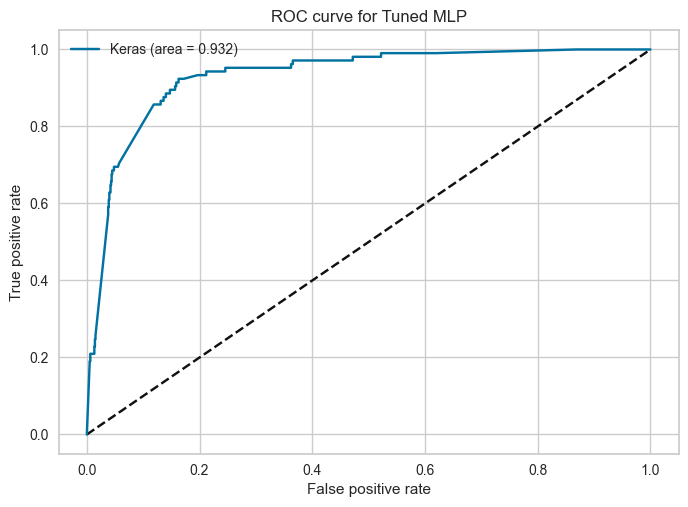

In [253]:
# finding threshold based on Youden's index 
y_pred_keras = nn.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Tuned MLP')
plt.legend(loc='best')
plt.show()

In [254]:
# Calculate the Youden's index at each threshold setting
j_scores = tpr_keras - fpr_keras

# Find the index of the threshold setting that maximizes the Youden's index
optimal_idx = np.argmax(j_scores)

# Get the optimal threshold value using the index
youdens_threshold = thresholds_keras[optimal_idx]

# Print the optimal threshold
print(youdens_threshold)

0.7401163


In [255]:
#get best params
params_nn = nn_bo.max['params']

learning_rate = params_nn['learning_rate']
activationL = ['relu', 'sigmoid', 'tanh', 'elu', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

optimizerL = ['Adam', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate==learning_rate), 'RMSprop':RMSprop(learning_rate=learning_rate)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]

dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
optimizer = best_params["optimizer"]

# final tuned model, inclusive of optimal threshold
nn_youden = Sequential()
#input layer + first hidden layer
nn.add(Dense(neurons, input_dim=X_train_nn.shape[1], activation=activation))
#hidden layer
for i in range(layers1):
    nn_youden.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn_youden.add(Dropout(dropout_rate, seed=42))
for i in range(layers2):
    nn_youden.add(Dense(neurons, activation=activation))
#output layer with 2 outputs
nn_youden.add(Dense(1, activation='sigmoid'))

# extract evaluation scores based on optimal threshold
nn_youden.compile(optimizer=optimizer, loss="binary_crossentropy", 
                 metrics=[Precision(thresholds=youdens_threshold), Recall(thresholds=youdens_threshold), 'accuracy', F1Score()])
es = EarlyStopping(monitor='val_loss', verbose=0, patience=20)
nn_youden.fit(X_train_nn, Y_train_nn, validation_data=(X_val_nn, Y_val_nn), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])   

In [256]:
# assign youden's threshold 
train_eval_nn = evaluate_model("MLP Training set eval", nn_youden, X_train_nn, Y_train_nn, youdens_threshold)
test_eval_nn = evaluate_model("MLP Testing set eval", nn_youden, X_test, Y_test, youdens_threshold)

youdens_threshold_accuracy = test_eval_nn[1]

221/221 [==============================] - 0s 695us/step
Classification report for MLP Training set eval: 
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.86      3552
         1.0       0.89      0.79      0.84      3509

    accuracy                           0.85      7061
   macro avg       0.85      0.85      0.85      7061
weighted avg       0.85      0.85      0.85      7061

34/34 [==============================] - 0s 735us/step
Classification report for MLP Testing set eval: 
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       977
         1.0       0.47      0.83      0.60       105

    accuracy                           0.89      1082
   macro avg       0.72      0.86      0.77      1082
weighted avg       0.93      0.89      0.90      1082



In [257]:
# overall accuracy
results = pd.concat([train_eval_nn[0], test_eval_nn[0]])
results

,Precision,Recall,Accuracy,F1 score
MLP Training set eval,0.889640,0.787974,0.855120,0.663955
MLP Testing set eval,0.465241,0.828571,0.890018,0.176917


Improvement in recall and F1, can consider using this threshold, but be mindful to that low threshold may lead to increase in False Positives.